In [1]:
# Brain MRI tumor segmentation with Otsu and Sauvola
# Simple notebook for my course project.

print("Brain MRI tumor segmentation notebook")

Brain MRI tumor segmentation notebook


In [5]:
%pip install pandas

  Using cached pandas-3.0.0-cp313-cp313-win_amd64.whl.metadata (19 kB)
  Using cached tzdata-2025.3-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-3.0.0-cp313-cp313-win_amd64.whl (9.7 MB)
Using cached tzdata-2025.3-py2.py3-none-any.whl (348 kB)

   ---------------------------------------- 0/2 [tzdata]
   ---------------------------------------- 0/2 [tzdata]
   ---------------------------------------- 0/2 [tzdata]
   ---------------------------------------- 0/2 [tzdata]
   ---------------------------------------- 0/2 [tzdata]
   -------------------- ------------------- 1/2 [pandas]
   -------------------- ------------------- 1/2 [pandas]
   -------------------- ------------------- 1/2 [pandas]
   -------------------- ------------------- 1/2 [pandas]
   -------------------- ------------------- 1/2 [pandas]
   -------------------- ------------------- 1/2 [pandas]
   -------------------- ------------------- 1/2 [pandas]
   -------------------- ------------------- 1/2 [pandas]
 


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
# Basic imports and paths for the project

import os
from pathlib import Path
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage import io, filters
from skimage.color import rgb2gray
from skimage.exposure import rescale_intensity, equalize_adapthist
from skimage.morphology import remove_small_objects, remove_small_holes, opening, disk

# Make plots appear inline and set a consistent style
plt.style.use("seaborn-v0_8")

PROJECT_ROOT = Path(r"C:\Users\kanha\Downloads\brain_tumor_dataset\project-1\Brain-mri-dataset")
DATA_ROOT = PROJECT_ROOT

print("Project root:", PROJECT_ROOT)
print("Data root:", DATA_ROOT)

image_dir = DATA_ROOT / "images"
mask_dir  = DATA_ROOT / "masks"

print("Images found:", len(list(image_dir.glob("*"))))
print("Masks found:", len(list(mask_dir.glob("*"))))




Project root: C:\Users\kanha\Downloads\brain_tumor_dataset\project-1\Brain-mri-dataset
Data root: C:\Users\kanha\Downloads\brain_tumor_dataset\project-1\Brain-mri-dataset
Images found: 3064
Masks found: 3053


In [7]:
"""Utility functions for loading MRI images and masks
for YOUR dataset structure:

Brain-mri-dataset/
    images/
    masks/
"""

from typing import List, Tuple

image_dir = DATA_ROOT / "images"
mask_dir  = DATA_ROOT / "masks"


def list_slice_pairs() -> List[Tuple[Path, Path]]:
    """Return (image_path, mask_path) pairs based on same filename."""
    img_paths = sorted(image_dir.glob("*"))
    pairs = []

    for img_path in img_paths:
        mask_path = mask_dir / img_path.name
        if mask_path.exists():
            pairs.append((img_path, mask_path))

    return pairs


def load_slice_and_mask(img_path: Path, mask_path: Path):
    """Load MRI slice + mask as normalized arrays."""
    img = io.imread(str(img_path))
    if img.ndim == 3:
        img = rgb2gray(img)

    img = rescale_intensity(img, in_range="image", out_range=(0.0, 1.0))

    mask = io.imread(str(mask_path))
    if mask.ndim == 3:
        mask = rgb2gray(mask)

    mask = (mask > 0).astype(np.uint8)

    return img, mask


# Quick test
example_pairs = list_slice_pairs()
print(f"#image-mask pairs found: {len(example_pairs)}")
print("First pair:", example_pairs[0])


#image-mask pairs found: 3053
First pair: (WindowsPath('C:/Users/kanha/Downloads/brain_tumor_dataset/project-1/Brain-mri-dataset/images/1008.png'), WindowsPath('C:/Users/kanha/Downloads/brain_tumor_dataset/project-1/Brain-mri-dataset/masks/1008.png'))


In [19]:
from skimage import exposure

def preprocess_image(img: np.ndarray) -> np.ndarray:
    """Enhance local contrast of a [0,1] MRI image."""
    img = np.clip(img, 0.0, 1.0)
    img_eq = exposure.equalize_adapthist(img, clip_limit=0.01)
    return img_eq


def clean_mask(mask: np.ndarray,
               min_obj_size: int = 50,
               min_hole_size: int = 50) -> np.ndarray:
    """Remove tiny noise and fill small holes."""
    mask_bool = mask.astype(bool)

    # remove tiny noisy regions
    mask_bool = remove_small_objects(mask_bool, max_size=min_obj_size)

    # fill small holes
    mask_bool = remove_small_holes(mask_bool, max_size=min_hole_size)

    # smooth edges slightly
    mask_bool = opening(mask_bool, footprint=disk(2))

    return mask_bool.astype(np.uint8)


def dice_score(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Compute Dice similarity coefficient between two binary masks."""
    y_true = y_true.astype(bool)
    y_pred = y_pred.astype(bool)
    intersection = np.logical_and(y_true, y_pred).sum()
    if y_true.sum() + y_pred.sum() == 0:
        return 1.0
    return 2.0 * intersection / (y_true.sum() + y_pred.sum())


def jaccard_index(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Compute Jaccard index (IoU) between two binary masks."""
    y_true = y_true.astype(bool)
    y_pred = y_pred.astype(bool)
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    if union == 0:
        return 1.0
    return float(intersection) / float(union)

C:\Users\kanha\AppData\Local\Temp\ipykernel_8452\3419716340.py:17: FutureWarning: Parameter `min_size` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_objects`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_bool = remove_small_objects(mask_bool, min_size=min_obj_size)
C:\Users\kanha\AppData\Local\Temp\ipykernel_8452\3419716340.py:20: FutureWarning: Parameter `area_threshold` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_holes`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask_bool = remov

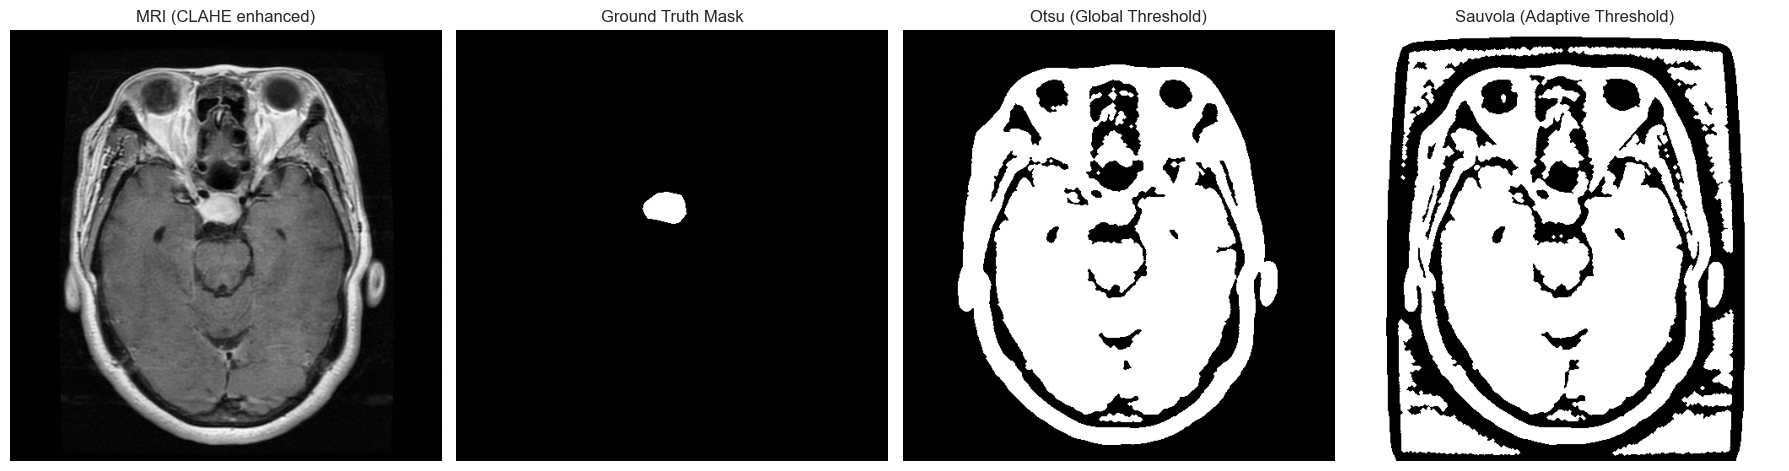

In [13]:
from skimage.filters import threshold_otsu, threshold_sauvola

def segment_otsu(img: np.ndarray, foreground: str = "bright") -> np.ndarray:
    img = np.clip(img, 0.0, 1.0)
    thresh = threshold_otsu(img)

    if foreground == "bright":
        mask = (img > thresh).astype(np.uint8)
    else:
        mask = (img < thresh).astype(np.uint8)

    return mask


def segment_sauvola(img: np.ndarray, window_size: int = 31, k: float = 0.2) -> np.ndarray:
    img = np.clip(img, 0.0, 1.0)
    local_thresh = threshold_sauvola(img, window_size=window_size, k=k)
    mask = (img > local_thresh).astype(np.uint8)
    return mask


# Visual check
img_path, mask_path = example_pairs[1]
img_ex_raw, mask_gt = load_slice_and_mask(img_path, mask_path)

img_ex = preprocess_image(img_ex_raw)

mask_otsu = clean_mask(segment_otsu(img_ex))
mask_sauv = clean_mask(segment_sauvola(img_ex))

fig, axes = plt.subplots(1, 4, figsize=(18, 5))

axes[0].imshow(img_ex, cmap="gray")
axes[0].set_title("MRI (CLAHE enhanced)")
axes[0].axis("off")

axes[1].imshow(mask_gt, cmap="gray")
axes[1].set_title("Ground Truth Mask")
axes[1].axis("off")

axes[2].imshow(mask_otsu, cmap="gray")
axes[2].set_title("Otsu (Global Threshold)")
axes[2].axis("off")

axes[3].imshow(mask_sauv, cmap="gray")
axes[3].set_title("Sauvola (Adaptive Threshold)")
axes[3].axis("off")

plt.tight_layout()
plt.show()


In [21]:
# ===== Evaluate Otsu vs Sauvola on your dataset =====

all_results = []

# Make sure example_pairs already exists:
# example_pairs = list_slice_pairs()

for img_path, mask_path in example_pairs[:100]:  # use first 100 images

    img_raw, mask_gt = load_slice_and_mask(img_path, mask_path)
    img = preprocess_image(img_raw)

    # Skip slices with almost no tumor
    if mask_gt.sum() < 20:
        continue

    # --- OTSU ---
    mask_otsu = clean_mask(segment_otsu(img, foreground="bright"))
    dice_otsu = dice_score(mask_gt, mask_otsu)
    jac_otsu  = jaccard_index(mask_gt, mask_otsu)

    # --- SAUVOLA ---
    mask_sauv = clean_mask(segment_sauvola(img, window_size=31, k=0.2))
    dice_sauv = dice_score(mask_gt, mask_sauv)
    jac_sauv  = jaccard_index(mask_gt, mask_sauv)

    all_results.append({
        "image": img_path.name,
        "dice_otsu": dice_otsu,
        "jaccard_otsu": jac_otsu,
        "dice_sauvola": dice_sauv,
        "jaccard_sauvola": jac_sauv,
    })

# Convert to DataFrame
results_df = pd.DataFrame(all_results)

print("Results preview:")
display(results_df.head())

print("\n===== FINAL METRICS =====")
print("Dice Otsu:", results_df["dice_otsu"].mean())
print("Dice Sauvola:", results_df["dice_sauvola"].mean())
print("Jaccard Otsu:", results_df["jaccard_otsu"].mean())
print("Jaccard Sauvola:", results_df["jaccard_sauvola"].mean())


Results preview:


,image,dice_otsu,jaccard_otsu,dice_sauvola,jaccard_sauvola
0,1008.png,0.037186,0.018945,0.021566,0.010900
1,1009.png,0.026407,0.013380,0.015708,0.007916
2,101.png,0.068203,0.035305,0.033418,0.016993
3,1010.png,0.019900,0.010050,0.011985,0.006028
4,1011.png,0.021643,0.010940,0.013748,0.006921



===== FINAL METRICS =====
Dice Otsu: 0.04850201270838114
Dice Sauvola: 0.028646391343257173
Jaccard Otsu: 0.02518096937625842
Jaccard Sauvola: 0.014603419301602177


In [20]:
# Quick summary table for the Dice and Jaccard scores

summary = results_df[[
    "dice_otsu",
    "dice_sauvola",
    "jaccard_otsu",
    "jaccard_sauvola",
]].agg(["mean", "std"]).T
summary.columns = ["mean", "std"]
summary

,mean,std
dice_otsu,0.048502,0.034502
dice_sauvola,0.028646,0.016644
jaccard_otsu,0.025181,0.018705
jaccard_sauvola,0.014603,0.008625
